<a href="https://colab.research.google.com/github/s1230038/autoencoder/blob/master/AutoencoderForThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Simple Autoencoder using Other Loss Function
# Original: https://elix-tech.github.io/ja/2016/07/17/autoencoder.html
# https://colab.research.google.com/drive/1Z_d8APkMUDwXDQIg3OI7E13vH8IZhusM?authuser=1#scrollTo=WmBfOis_mWCH
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from keras import losses

# imititing mean_squared_error():
# 青イルカ P.57では二乗誤差の総和を使用しているが、これをKerasで実装する場合は平均二乗誤差（mean_squared_error)
# をloss に渡す必要がある。なぜなら、Kerasはミニバッチでfit()を計算するからである。青イルカ P.27参照。
# 𝒙 ̂_𝑛 :y_pred,  𝒙_𝑛 : y_true, because x_n is training data which means label.
def i_divergence1(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean(y_pred * K.log(y_pred / y_true) - y_pred + y_true, axis=-1)

def i_divergence2(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean(y_true * K.log(y_true / y_pred) - y_true + y_pred, axis=-1)

def is_divergence1(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean( (y_pred / y_true) - K.log(y_pred / y_true) - 1, axis=-1)

def is_divergence2(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean( (y_true / y_pred) - K.log(y_true / y_pred) - 1, axis=-1)

for loss in [losses.mean_squared_error, i_divergence1, i_divergence2, is_divergence1, is_divergence2]:
  print("start: " + loss.__name__)
  encoding_dim = 32
  input_img = Input(shape=(784,))
  #　Let us apply ReLU to both encoder activation and decoder activation。 
  encoded = Dense(encoding_dim, activation='relu')(input_img)
  decoded = Dense(784, activation='relu')(encoded) 
  autoencoder = Model(inputs=input_img, outputs=decoded) # https://medium.com/@zhuixiyou/userwarning-update-your-model-call-to-the-keras-2-api-8a6a5955daac
  # autoencoderでは、教師データにラベルを使わないためaccuracyの計算は不要。
  autoencoder.compile(optimizer='adam', loss=loss)

  # Download MNIST and standardize, learning
  (x_train, _), (x_test, _) = mnist.load_data()
  # we will restrict domain of definition of the input data to the below expression with normalization of the input.
  x_train = x_train.astype('float32') / 255. # 画像データは0から1の実数値を取るように規格化
  x_test = x_test.astype('float32') / 255.   # {0,1}の二値ではなく実数値であることに注意
  # x_trainは (60000, 28, 28) という形をしていますが、784次元の入力になるように (60000, 784) に変形
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

  autoencoder.fit(x_train, x_train,
                  nb_epoch=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

  # 学習した重みを保存
  autoencoder.save_weights( loss.__name__ + 'autoencoder.h5')
  

start: mean_squared_error


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0395 - val_loss: 0.0213
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0182 - val_loss: 0.0157
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.0153 - val_loss: 0.0143
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0144 - val_loss: 0.0139
Epoch 5/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0141 - val_loss: 0.0136
Epoch 6/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0139 - val_loss: 0.0135
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0138 - val_loss: 0.0135
Epoch 8/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0138 - val_loss: 0.0134
Epoch 9/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0137 - val_loss: 0.0134
Epoch

show: mean_squared_error


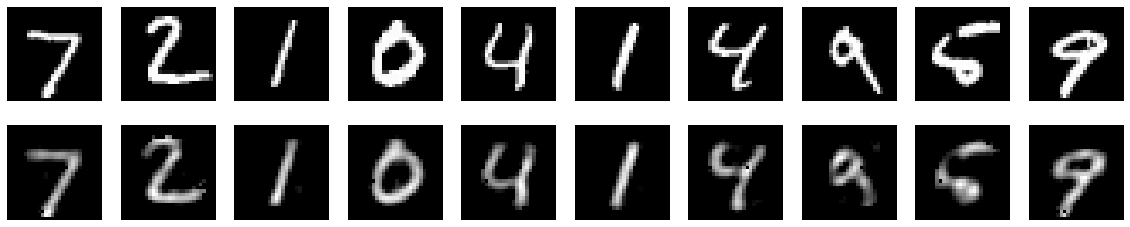

show: i_divergence1


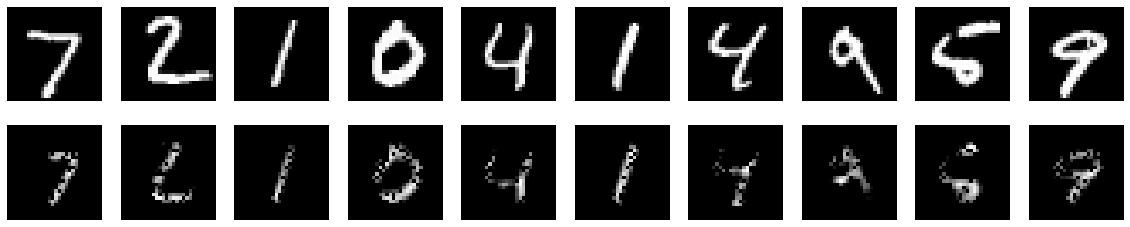

show: i_divergence2


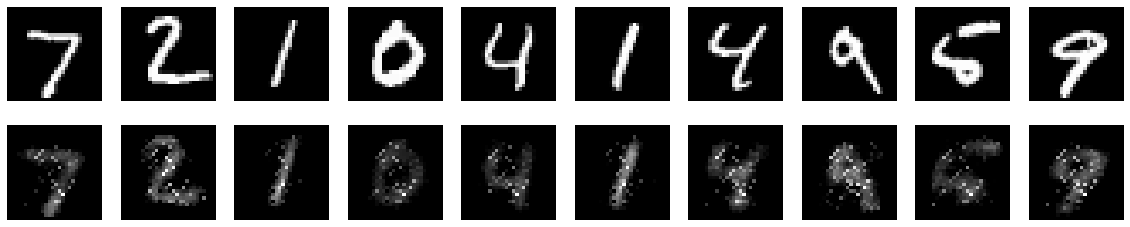

show: is_divergence1


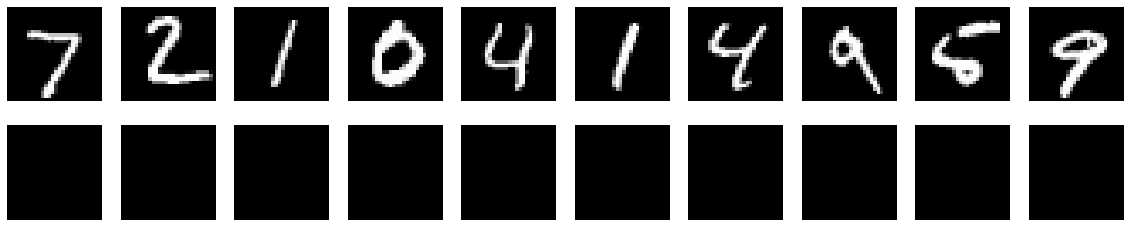

show: is_divergence2


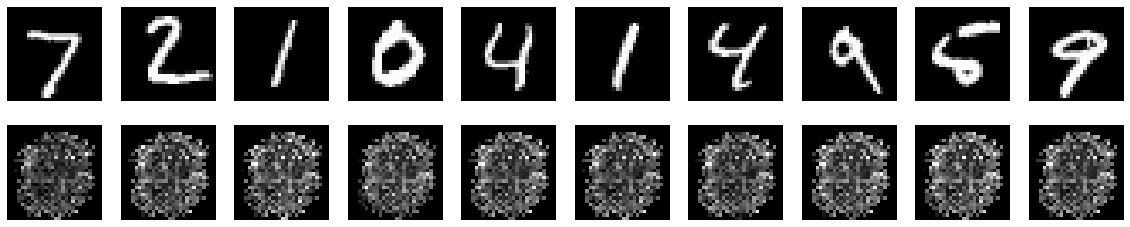

In [7]:
import matplotlib.pyplot as plt

for loss in [losses.mean_squared_error, i_divergence1, i_divergence2, is_divergence1, is_divergence2]:
  print("show: " + loss.__name__)
  # 保存した重みを読み込み
  autoencoder.load_weights(loss.__name__ + 'autoencoder.h5')
  decoded_imgs = autoencoder.predict(x_test)
  # 何個表示するか
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # オリジナルのテスト画像を表示
      ax = plt.subplot(2, n, i+1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # 変換された画像を表示
      ax = plt.subplot(2, n, i+1+n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))